In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras, profiler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import time
import torch
%matplotlib inline

## Define models and useful functions

In [3]:
# define model architecture

def create_LeNet(image_size = (28, 28)):
    model = tf.keras.Sequential([
        # tf.keras.layers.Rescaling(1./255),
        keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, input_shape = image_size, activation="relu"), 
        keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        keras.layers.Conv2D(16, 5, 1, activation='relu'),
        keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        keras.layers.Flatten(),
        keras.layers.Dense(120, activation='relu'), # param increase here
        keras.layers.Dense(84, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [ ]:
# This function consider synchronous execution and GPU aspects to measure time more accurately

def profile_inf_time(img_expanded, model):
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    repetitions = 400
    timings=np.zeros((repetitions,1))
    #GPU-WARM-UP
    for _ in range(10):
        _ = model.predict(img_expanded)
    # MEASURE PERFORMANCE
    for rep in range(repetitions):
        starter.record()
        _ = model.predict(img_expanded)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    time.sleep(1) # to avoid interference between each execution
    return mean_syn

In [ ]:
# determine the memory in bytes
number_size = 4.0 # default 'float32' -> memory = 4 Bytes
if K.floatx() == 'float16':
        number_size = 2.0
if K.floatx() == 'float64':
        number_size = 8.0

## Measure no. of parameters, model memory size and inference time

In [ ]:
img_size_list = []
n_params_list = []
infer_time_list = []

for i in range(1,17):
    # dummy image
    img_shape = (16*i, 16*i, 3)
    img = np.random.randint(0, 255, img_shape)
    img_expanded = np.expand_dims(img, axis=0)
    # built-in model - doesn't change no. of parameters with image shape 
    # processed_img = tf.keras.applications.vgg16.preprocess_input(img_expanded) 
    # model = tf.keras.applications.VGG16(input_shape = img_shape, classes=10, include_top=False, weights=None)
    # custom model
    model = create_LeNet(img_shape)
    curr_time = profile_inf_time(img_expanded, model)
    # get model stats
    n_params = model.count_params()
    print(f"Image shape:{img_shape[0]},\t No. of params:{n_params},\t Memory:{n_params * number_size},\t Inference time:{curr_time}")
    # append to list
    img_size_list.append(img_shape[0])
    n_params_list.append(n_params)
    infer_time_list.append(curr_time)

Image shape:16,	 No. of params:15926,	 Memory:63704.0,	 Inference time:50.71701790809632
Image shape:32,	 No. of params:62006,	 Memory:248024.0,	 Inference time:51.974321126937866
Image shape:48,	 No. of params:169526,	 Memory:678104.0,	 Inference time:52.7136953163147
Image shape:64,	 No. of params:338486,	 Memory:1353944.0,	 Inference time:52.454078893661496
Image shape:80,	 No. of params:568886,	 Memory:2275544.0,	 Inference time:52.001128349304196
Image shape:96,	 No. of params:860726,	 Memory:3442904.0,	 Inference time:52.19270341873169
Image shape:112,	 No. of params:1214006,	 Memory:4856024.0,	 Inference time:52.31022965431213
Image shape:128,	 No. of params:1628726,	 Memory:6514904.0,	 Inference time:52.99599234580994
Image shape:144,	 No. of params:2104886,	 Memory:8419544.0,	 Inference time:52.88547499656677
Image shape:160,	 No. of params:2642486,	 Memory:10569944.0,	 Inference time:53.47613292694092
Image shape:176,	 No. of params:3241526,	 Memory:12966104.0,	 Inference tim

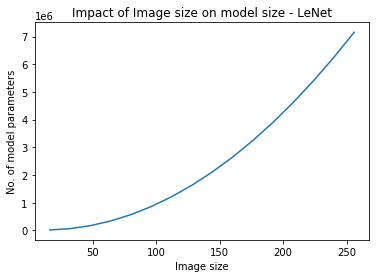

In [ ]:
plt.plot(img_size_list, n_params_list)
plt.xlabel("Image size")
plt.ylabel("No. of model parameters")
plt.title("Impact of Image size on model size - LeNet")
plt.show()

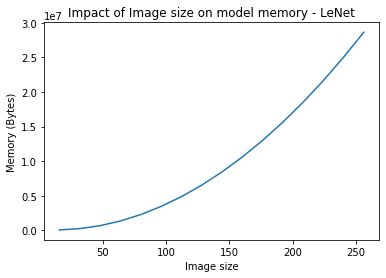

In [ ]:
memory_list = [p * number_size for p in n_params_list]
plt.plot(img_size_list, memory_list)
plt.xlabel("Image size")
plt.ylabel("Memory (Bytes)")
plt.title("Impact of Image size on model memory - LeNet")
plt.show()

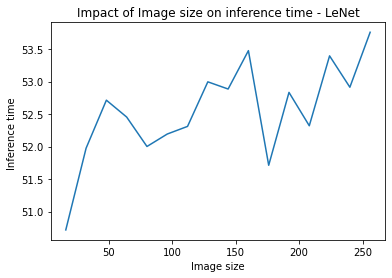

In [ ]:
plt.plot(img_size_list, infer_time_list)
plt.xlabel("Image size")
plt.ylabel("Inference time ")
plt.title("Impact of Image size on inference time - LeNet")
plt.show()

## Investigating the impact layer

In [ ]:
i=1
img_shape = (16*i, 16*i, 3) # 64 x 64
model = create_LeNet(img_shape)
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 12, 12, 6)         456       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 6, 6, 6)          0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 2, 2, 16)          2416      
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 1, 1, 16)         0         
 g2D)                                                            
                                                                 
 flatten_38 (Flatten)        (None, 16)                0         
                                                                 
 dense_114 (Dense)           (None, 120)             

In [ ]:
i=4
img_shape = (16*i, 16*i, 3)
model = create_LeNet(img_shape)
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 60, 60, 6)         456       
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 30, 30, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 flatten_39 (Flatten)        (None, 2704)              0         
                                                                 
 dense_117 (Dense)           (None, 120)             

## Measure Performance and Training time


In [5]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = keras.datasets.cifar10.load_data()
	# one hot encode target values
	trainY = keras.utils.to_categorical(trainY)
	testY = keras.utils.to_categorical(testY)
	return trainX, trainY, testX, testY
 
data = load_dataset()
data[0].shape

170508288/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3)

In [10]:
trainX = list(map( lambda x: tf.image.resize(x, (16, 16)), data[0]))
trainX = np.array(trainX)
print(trainX.shape)

(50000, 16, 16, 3)


In [19]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = keras.datasets.cifar10.load_data()
	# one hot encode target values
	trainY = keras.utils.to_categorical(trainY)
	testY = keras.utils.to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test, img_size):
    # resize the images
    train = np.array(list(map( lambda x: tf.image.resize(x, (img_size, img_size)), train)))
    test = np.array(list(map( lambda x: tf.image.resize(x, (img_size, img_size)), test)))
	# convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
	# normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
	# return normalized images
    return train_norm, test_norm
 
# define cnn model
def define_model(img_shape):
	model = create_LeNet(img_shape)
	# compile model
	opt = keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test'); plt.show()

 
# run the test harness for evaluating a model
def train_n_eval(img_shape):
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX, img_shape[0])
	# define model
	model = define_model(img_shape)
	# fit model
	history = model.fit(trainX, trainY, epochs=2, batch_size=64, validation_data=(testX, testY), verbose=0)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


391/391 [==============================] - 2s 5ms/step - loss: 2.2493 - accuracy: 0.1632 - val_loss: 2.0912 - val_accuracy: 0.2244
Epoch 2/10
391/391 [==============================] - 2s 4ms/step - loss: 1.9934 - accuracy: 0.2627 - val_loss: 1.9204 - val_accuracy: 0.2942
Epoch 3/10
391/391 [==============================] - 2s 4ms/step - loss: 1.8608 - accuracy: 0.3235 - val_loss: 1.7802 - val_accuracy: 0.3588
Epoch 4/10
391/391 [==============================] - 2s 4ms/step - loss: 1.7245 - accuracy: 0.3745 - val_loss: 1.6477 - val_accuracy: 0.3966
Epoch 5/10
391/391 [==============================] - 2s 4ms/step - loss: 1.6319 - accuracy: 0.4076 - val_loss: 1.6650 - val_accuracy: 0.4014
Epoch 6/10
391/391 [==============================] - 2s 4ms/step - loss: 1.5658 - accuracy: 0.4346 - val_loss: 1.5436 - val_accuracy: 0.4408
Epoch 7/10
391/391 [==============================] - 2s 4ms/step - loss: 1.5273 - accuracy: 0.4471 - val_loss: 1.5443 - val_accuracy: 0.4402
Epoch 8/10
391/39

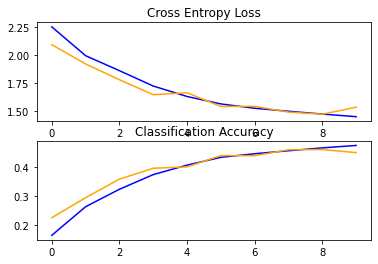

In [18]:
img_size_list = []
acc_list = []
infer_time_list = []

for i in range(1,2): #17
    # define image shapes
    img_shape = (16*i, 16*i, 3)
    img_size_list.append(img_shape[0]) ## save
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
    trainX, testX = prep_pixels(trainX, testX, img_shape[0])
	# define model
    model = define_model(img_shape)
	# fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=128, validation_data=(testX, testY))
	# evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    acc_list.append(acc) ## save
	# learning curves
    summarize_diagnostics(history)

